In [2]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import random_clifford
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt
from quantum_logical.basis import RepetitionEncoding
from quantum_logical.basis import QutritPhaseRepetitionCode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passmanager import PassManager
from qiskit.converters import circuit_to_dag
from quantum_logical.encoded_layout import EncodedLayout
from qiskit.quantum_info import Operator
import numpy as np

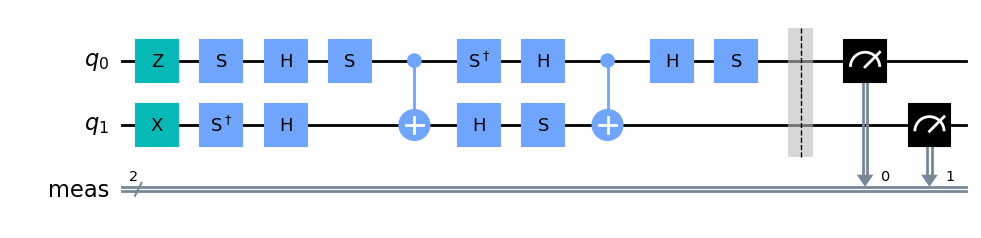

In [3]:
input_circuit = random_clifford(2, seed=1).to_circuit()
input_circuit = transpile(
    input_circuit,
    basis_gates=["sdg", "s", "h", "hdg", "x", "xdg", "z", "zdg", "cx", "id"],
    optimization_level=3,
)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


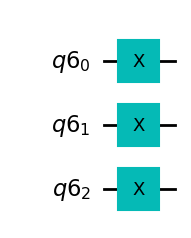

In [4]:
qr = QuantumRegister(3)
qc = QuantumCircuit(qr)

encoding1 = RepetitionEncoding(phase_flip=False)
# qc.x(qr)
qc.x(0)
qc.x(1)
qc.x(2)
qc.draw("mpl")

In [5]:
circ_op = Operator(qc).data
op = encoding1.transform_operator.full()

# new_op = np.kron(op, op).conj().T @ circ_op @ np.kron(op, op)
new_op = op.conj().T @ circ_op @ op
new_op.round()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [6]:
from quantum_logical.encoded_layout import EncodedEquivalenceLibrary
from qiskit.circuit.library import ZGate, XGate

# Usage example
encoding1 = EncodedEquivalenceLibrary(code_length=3)
encoding1.add_equivalence(ZGate(), qc)

Look how bad decomposition is without explicitly defining the logical/encoded equivalence library. The transpiler is not well-suited for multi-qubit decomposition:

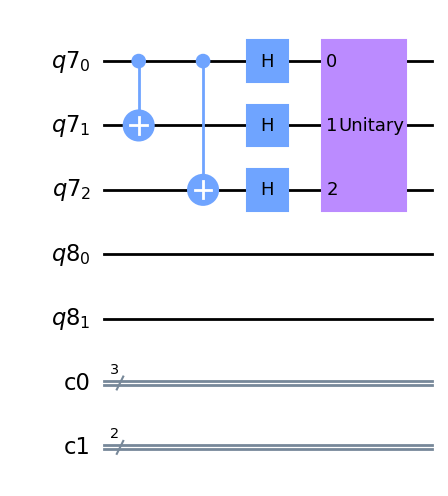

In [7]:
qr = QuantumRegister(3)
ar = QuantumRegister(2)
cqr = ClassicalRegister(3)
car = ClassicalRegister(2)
qc = QuantumCircuit(qr, ar, cqr, car)

encoding1 = RepetitionEncoding(phase_flip=True)
qc = encoding1.encoding_circuit(qc, qr)
new_op = op @ XGate().to_matrix() @ op.conj().T
new_op.round()
from quantum_logical.deprecated.unitary_util import ImplicitUnitaryGate

qc.append(ImplicitUnitaryGate(new_op), qr)
qc.draw("mpl")

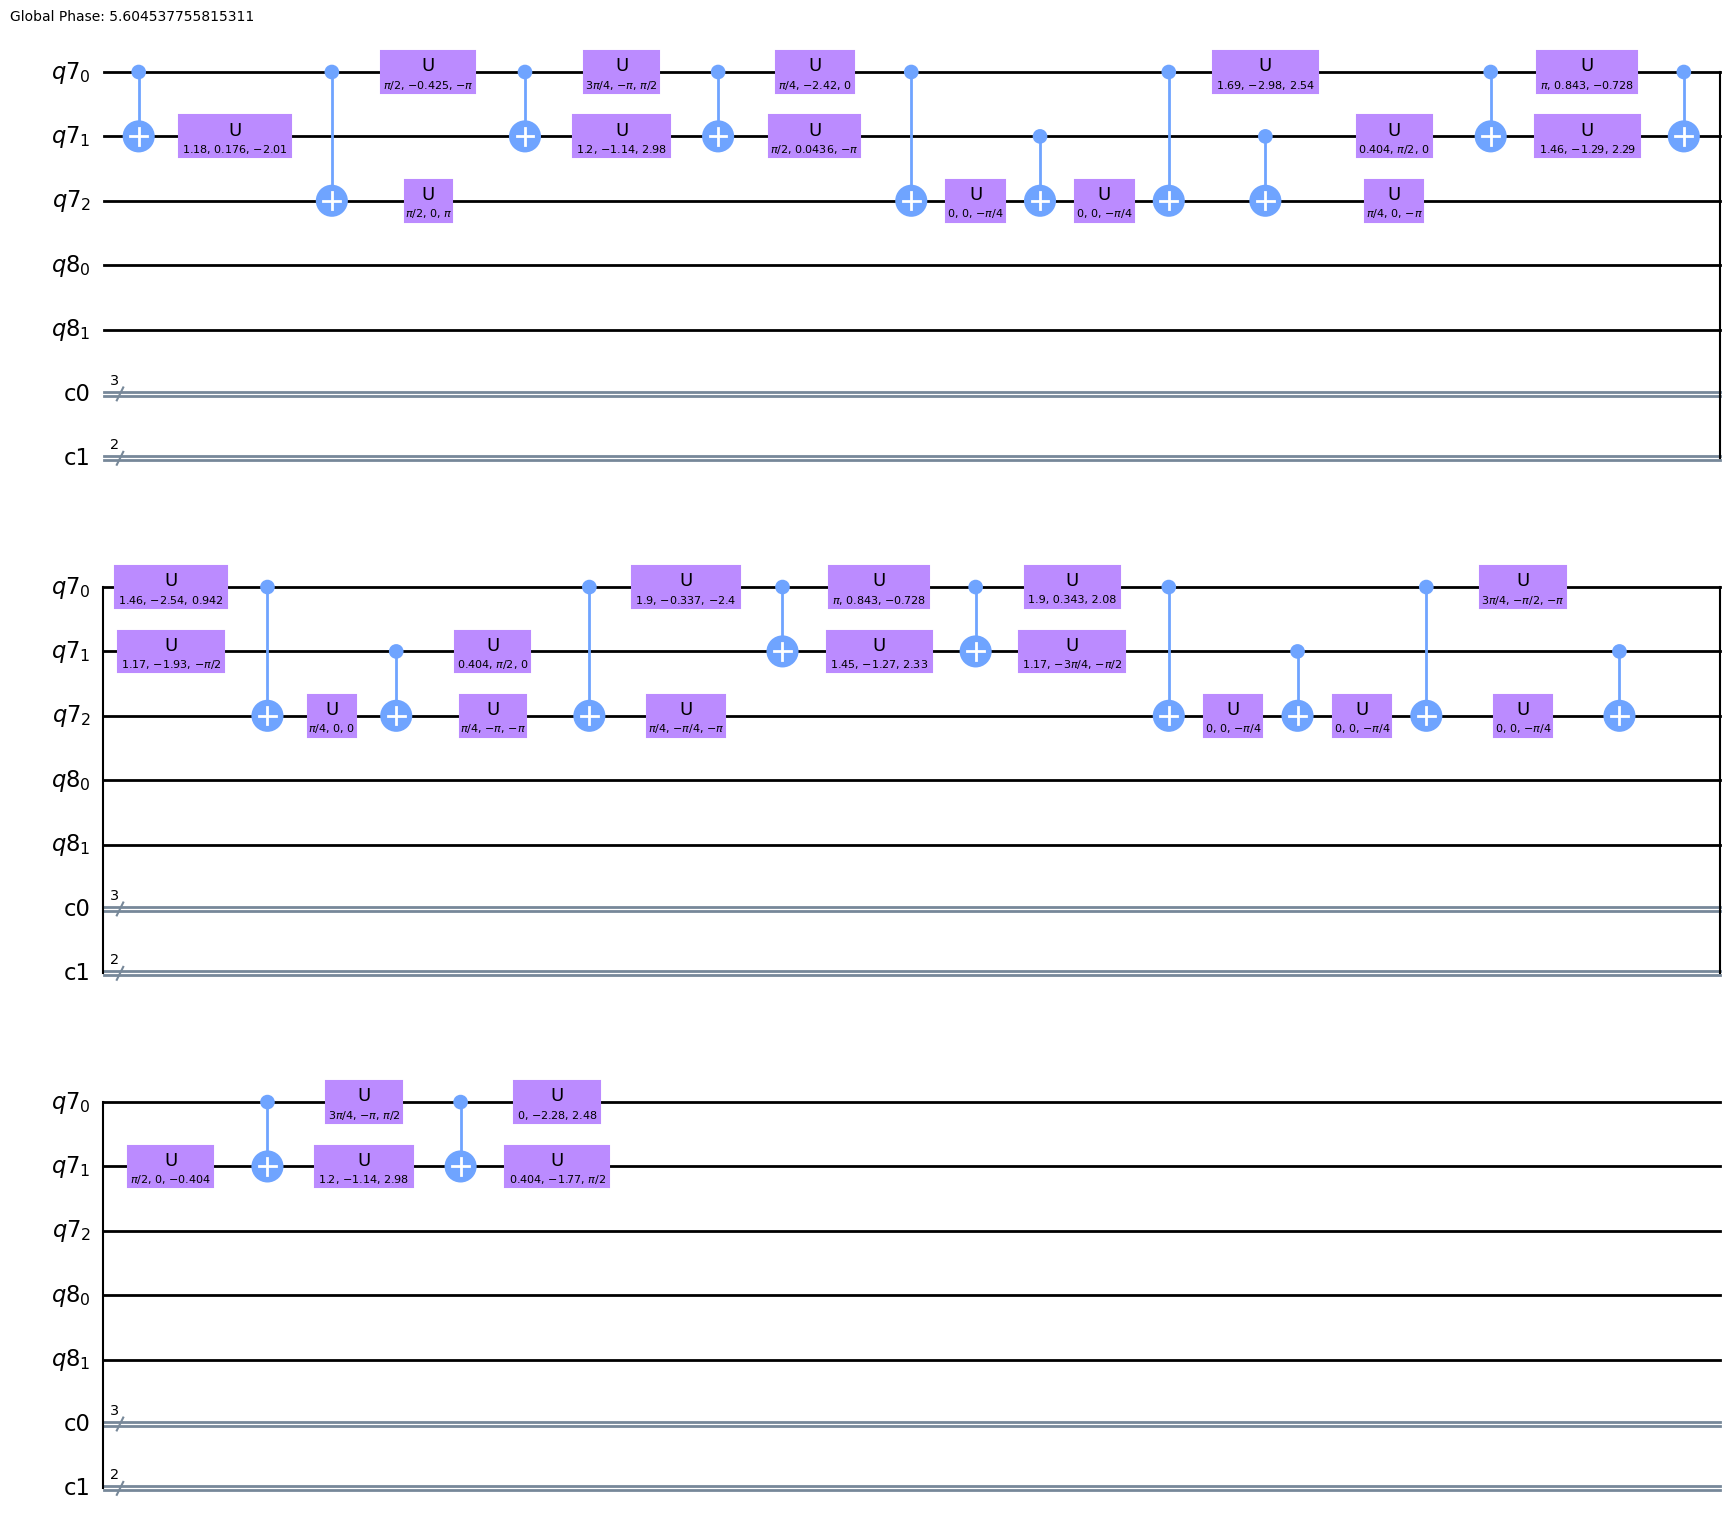

In [8]:
transpile(
    qc,
    basis_gates=["u", "cx"],
).draw("mpl")